In order to forecast using estimates from the delay distribution we develop the following notation. 


Suppose we have a time series $Y_1,Y_2,...,Y_n$ indexed by a sequence of time values $t_1,t_2,...,t_n$. We adopt the forecasting notation of Reich et. al (2018) in order to evaluate targets across models. 

Suppose we are interested in forecasting $Y_j$ at time $t_j$. Because of the delay nature of the data we only observe **complete** data up till time $t_j - L$ for a fixed L. 


For example, if $t_j$ is "now" then $t_j - L$ is the last $t^*$ for which all possible delay values $t^*,t^*+1, ....,+ t^*+L$ are completely observed. 

We define the following prediction $z(t_j - L +k | t_j)$ to be the *k-step* ahead prediction relative to time $t_j$. We define the MSE of model $M$ to be 

$$MSE_{t_j}(M) = \frac{1}{L}\sum_{k=0}^L [z(t_j - L +k | t_j) - Y_{j-L+k}]^2$$

In order to compute an average MSE over the full model $M$ we compute 

$$MSE(M) = \frac{1}{dim(T)}\sum_{t_j \in T}MSE_{t_j}(M)$$


For this experiment we examine 2 models 

$$M_1 = \text{ process model ignorning delay }$$

$$M_2 = \text{ process model weighted by delay distribution }$$



In [26]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Sat Jan  6 17:12:30 2018

@author: gcgibson
"""

import scipy.stats
import sys
import numpy as np
from numpy.random import random
import math
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason

def observation_function(time_series_at_t,t,D,particle,params):
    
    tmp =  scipy.stats.poisson.pmf(time_series_at_t,np.exp(particle))
    if math.isnan(tmp):
        tmp = 0
    return tmp

def transition_function(particles,params):
    particles[:,0]  += np.random.normal(0,1,len(particles))
    return particles

def expected_value_observation_function(p):
    return np.exp(p)

def expected_value_transition_function(p):
    return p

def create_uniform_particles( N,state_space_dimension):
    particles  = np.random.normal(0,1 , size=(N,state_space_dimension))
    return particles

def predict(particles,t,params):
    particles = transition_function(particles,params)
    return particles


def update(particles, weights,ts,t,D,params):
    weights.fill(1.)
    for p in range(len(particles)):
        weights[p] *= observation_function(ts[t],t,D,particles[p],params)
    weights += 1.e-300
    return weights/sum(weights)  



def neff(weights):
    return 1. / np.sum(np.square(weights))


def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""
    pos = particles[:, 0]
    mean = np.average(pos, weights=weights, axis=0)
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var

### VARIOUS RESAMPLING SCHEMES
def multinomal_resample(weights):
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1.  # avoid round-off errors
    return np.searchsorted(cumulative_sum, random(len(weights)))


def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights[:] = weights[indexes]
    weights.fill(1.0 / len(weights))
    return particles,weights

def stratified_resample(weights):
    N = len(weights)
    # make N subdivisions, chose a random position within each one
    positions = (random(N) + range(N)) / N

    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)

    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes



def run_pf(time_series,N,state_space_dimension,D,params):
    
    particles = create_uniform_particles(N=N,state_space_dimension=state_space_dimension)
    weights = np.zeros(N)    
    xs = [] 
    ws = []
    ws.append(weights)
    for t in range(len(time_series)):
        particles = predict(particles,t,params)       
        # incorporate measurements
        weights = update(particles, weights,time_series, t, D, params)
        ws.append(weights)
        #print (neff(weights),time_series[t],params)
        indexes = stratified_resample(weights)
        particles,weights = resample_from_index(particles, weights, indexes)
        mu, var = estimate(particles, weights)
        xs.append(mu.tolist())
    return xs,particles,ws

 


"""
Suppose we are given data in the form 

n_{0,0} , n_{0,1} , n_{0,2}, n_{0,3}
n_{1,0} , n_{1,1} , n_{1,2}, 0
n_{2,0} , n_{2,1} , 0      , 0
n_{3,0} , 0       , 0      , 0

where T=3.

Now suppose D=2, then we truncate this matrix as follows

n_{0,0} , n_{0,1} , n_{0,2}, 0
n_{1,0} , n_{1,1} , n_{1,2}, 0
n_{2,0} , n_{2,1} , 0      , 0
n_{3,0} , 0       , 0      , 0


so for a setting of parameters (T=2,D=3) the reporting trapezoid is completely 
defined

In order to get the N_{t,T}s we simply add up the rows


"""
SIMULATE = False
D = 30
if SIMULATE == False:
    n_t_d = []
    with open("province-biweek_with_delays.csv") as f:
        i = 0
        for line in f.readlines():
            if i > 0:
                n_t_d.append(line.replace("\n","").split(','))
            i+=1
    date_to_index = {}
    
    i = 0
    for elm in n_t_d:
        if len(elm[1]) == 1:
            elm[1] = "0" + elm[1]
        date_to_index[elm[0]+elm[1]] = i
    
        i+=1
    
    d_to_i = {}
    i = 0
    iter_ =  date_to_index.keys()
    iter_.sort()
    for key in iter_:
    
        d_to_i[key] = i
        i+=1
    
    n_t = np.zeros((52-1,52-1))
    
    for elm in n_t_d:
        try:
            
            sick_date = d_to_i[elm[0]+elm[1]]
            report_date = d_to_i[elm[4] + elm[5]]
            if int(elm[4] + elm[5]) < 201621 and int(elm[3]) == 1:
                n_t[sick_date][report_date] += int(elm[3])
            
        except:
            pass
    
    
   
    
    n_t_d = []
    for row in range(len(n_t)):
        #if len(n_t[row][row:row+D]) == D:
            tmp = n_t[row][row:row+D].tolist()
            while len(tmp) < D:
                tmp += [0]
            n_t_d.append(tmp)
    
    n_t_d = np.array(n_t_d)
    
    n_t_inf = np.sum(n_t_d,axis=1)

else:
    true_p = [.1,.3,.2,.15,.15,.1]
    n_t_d = []
    n_t_inf = []
    states = []
    tmp = np.random.normal(4,1 ,1)
    states.append(tmp)
    n_t_inf.append(np.random.poisson(np.exp(tmp))[0])
    for i in range(1,10):
        tmp = np.random.normal(states[i-1],1,1)
        states.append(tmp)
        n_t_inf.append(np.random.poisson(np.exp(tmp))[0])
    for i in range(len(n_t_inf)):
        n_t_d.append(np.random.multinomial(n_t_inf[i],true_p).tolist())
        
    


total_mse_m1 = 0
total_mse_m2 = 0

print (n_t_d.shape)

## 51x10
print (n_t_inf.shape)

## 51




(51, 30)
(51,)


100%|██████████| 50500/50500 [00:11<00:00, 4534.46it/s]


Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


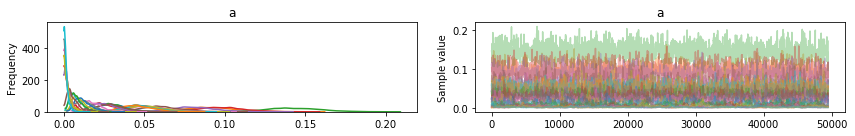

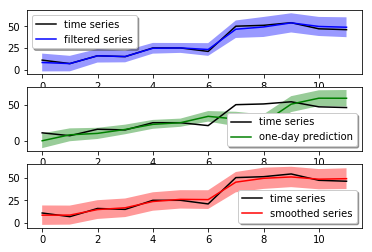

MSE ignoring delay
7257.145826959117
MSE delay adjusted
5085.622759233576
MSE taking most likely trajectory
5335.2784035588575


100%|██████████| 50500/50500 [00:11<00:00, 4363.58it/s]


Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


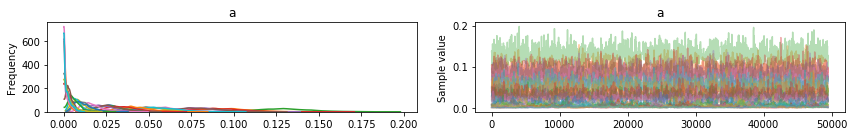

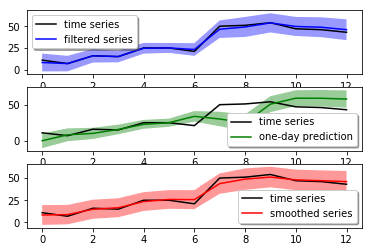

MSE ignoring delay
4745.675571557152
MSE delay adjusted
3601.775127653383
MSE taking most likely trajectory
3676.563000898496

100%|██████████| 50500/50500 [00:12<00:00, 4000.19it/s]



Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


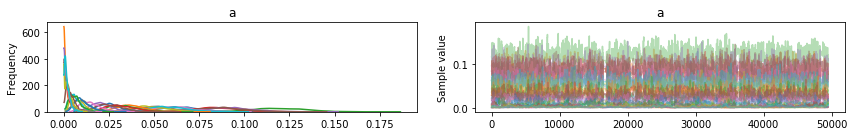

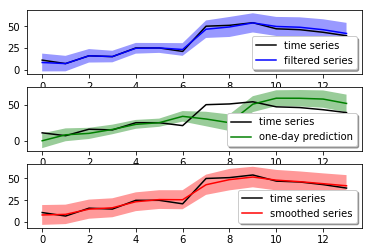

MSE ignoring delay
2340.6599719842084
MSE delay adjusted
2179.4710670495256
MSE taking most likely trajectory
2272.8024600697863


100%|██████████| 50500/50500 [00:11<00:00, 4284.14it/s]


Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


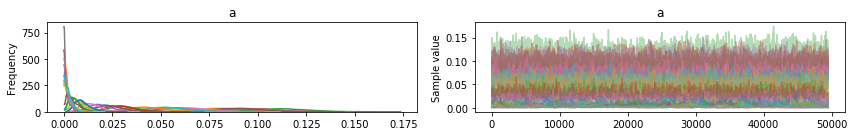

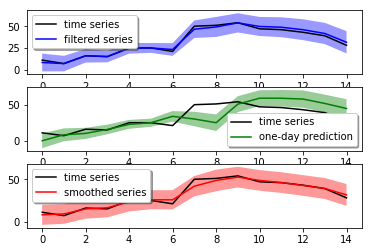

MSE ignoring delay
424.3399855942851
MSE delay adjusted
1692.4643170926663
MSE taking most likely trajectory
1787.1321541644165


100%|██████████| 50500/50500 [00:12<00:00, 3940.90it/s]


Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


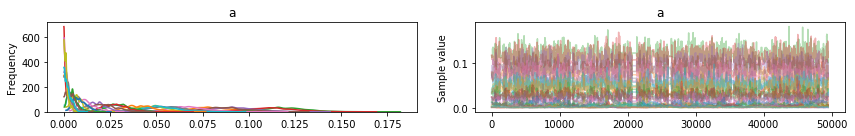

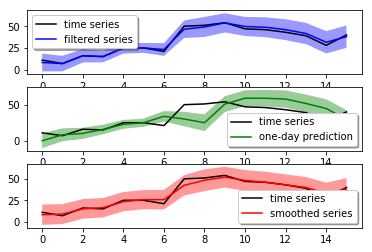

MSE ignoring delay
980.5526734538128
MSE delay adjusted
1442.0934688662956
MSE taking most likely trajectory
1536.5289032168657


100%|██████████| 50500/50500 [00:12<00:00, 4194.44it/s]


Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


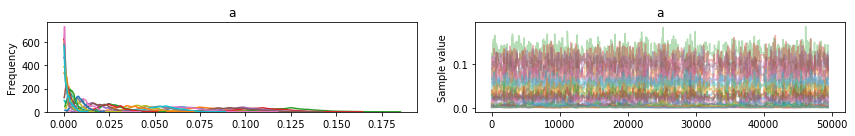

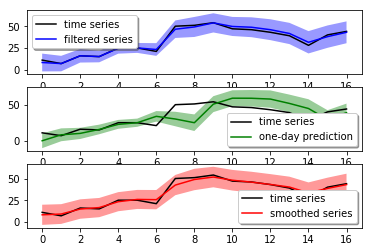

MSE ignoring delay
1618.1276246869515
MSE delay adjusted
1626.8756775533407
MSE taking most likely trajectory
1837.618239878332


100%|██████████| 50500/50500 [00:18<00:00, 2774.69it/s]


Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


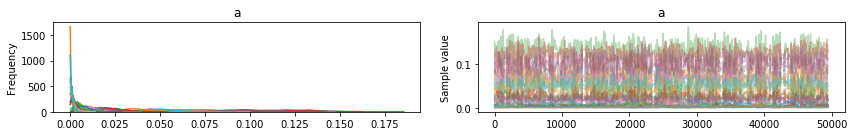

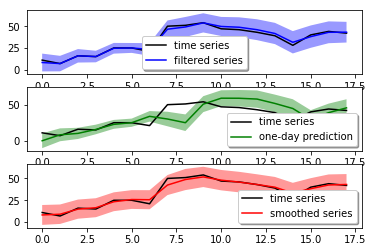

MSE ignoring delay
1516.6876176585924
MSE delay adjusted
1408.7153400074433
MSE taking most likely trajectory
1573.683152417232


100%|██████████| 50500/50500 [00:12<00:00, 4103.80it/s]


Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


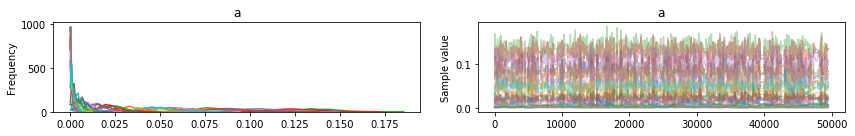

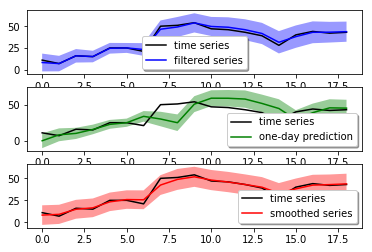

MSE ignoring delay
1606.0298086567168
MSE delay adjusted
1322.3103576718688
MSE taking most likely trajectory
1520.8652328363141


100%|██████████| 50500/50500 [00:12<00:00, 4060.59it/s]


Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


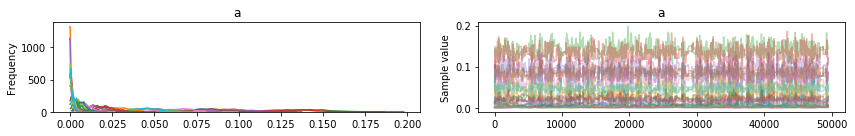

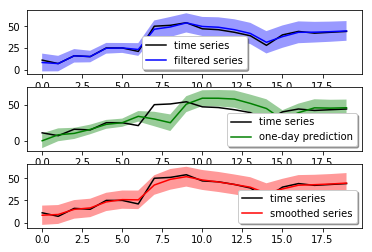

MSE ignoring delay
1763.6091290015122
MSE delay adjusted
1121.9789083898154
MSE taking most likely trajectory


In [ ]:

T = range(len(n_t_d)-10,len(n_t_d))
for tau in T:


    train_n_t_d = n_t_d[:tau-D + 1]
    train_n_t_inf = n_t_inf[:tau-D + 1]

    test_n_t_d = n_t_d[tau- D + 1:tau ]
    test_n_t_inf = n_t_inf[tau-D +1:tau ]
    #print (test_n_t_inf.shape)
    

    import numpy as np
    import pymc3 as pm
    import pandas as pd


    ## Delay Model

    DELAY_DIST = True
    if DELAY_DIST == True:

        k = np.array(train_n_t_d).shape[1 ]

        with pm.Model() as multinom_test:
            a = pm.Dirichlet('a', a=np.ones(k))
            for i in range(len(train_n_t_d)):
                data_pred = pm.Multinomial('data_pred_%s'% i, n=sum(train_n_t_d[i]), p=a, observed=train_n_t_d[i])
            trace = pm.sample(50000, pm.Metropolis())
            #trace = pm.sample(1000) # also works with NUTS

        pm.traceplot(trace[500:]);

    state_trajectories = []
    PF = False
    if  PF:
        N = 10000
        state_space_dimension = 1

        params = []
        means , particles, weights = run_pf(train_n_t_inf,N,state_space_dimension,D,params)



        ### Interval Predictions
        state_trajectories = [particles]
        observation_trajectories = [np.exp(particles)]
        for i in range(len(test_n_t_inf)):
            tmp = expected_value_transition_function(state_trajectories[i-1])
            observation_trajectories.append(expected_value_observation_function(tmp))
            state_trajectories.append(tmp) 

        state_trajectories = state_trajectories[1:]
        ## MEAN
        #print (np.mean(observation_trajectories,axis=1))
        ## QUANTILES 
        state_trajectories = np.array(state_trajectories).reshape((len(test_n_t_inf),-1))


    else:
        myDLM = dlm(train_n_t_inf)
        myDLM = myDLM + trend(1, name='lineTrend', w=1.0)
        # add a 7 day seasonality with prior covariance 1.0
        myDLM = myDLM + seasonality(52, name='7day', w=1.0)
        # add a 3 step auto regression
        myDLM = myDLM + autoReg(degree=2, data=train_n_t_inf, name='ar3', w=1.0)
        myDLM.fit()
        (predictMean, predictVar) = myDLM.predictN(N=D-1, date=myDLM.n-1)




    for i in range(len(predictMean)):
        samples = np.random.normal(predictMean[i],np.sqrt(predictVar[i]),100)
        state_trajectories.append(samples)
    state_trajectories = np.array(state_trajectories)


    phat = trace['a'].mean(axis=0)
    from scipy.stats import binom



    myDLM.plot()

    ##compute weighted trajectories 

    weighted_trajectories = []
    for i in range(len(state_trajectories)):
        tmp = []
        samples = state_trajectories[i]
        row_sum = sum(test_n_t_d[i])
        q = sum(phat[:len(phat)-i-1])
        for samp in samples:
            btemp = binom.pmf(row_sum,samp,q)
            if np.isnan(btemp):
                tmp.append(0)
            else:
                tmp.append(btemp)
            #print (row_sum,samp,q,btemp)
        weighted_trajectories.append(tmp)
    weighted_trajectories = np.array(weighted_trajectories)

    
    for i in range(len(weighted_trajectories)):
        weighted_trajectories[i] = weighted_trajectories[i]/sum(weighted_trajectories[i])
    where_are_NaNs = np.isnan(weighted_trajectories)
    weighted_trajectories[where_are_NaNs] = 1e-50
    #print (weighted_trajectories)
    ###
    from sklearn.metrics import mean_squared_error



    max_indeces = np.argmax(weighted_trajectories,axis=1)
    max_point = []
    for i in range(len(max_indeces)):
        max_point.append(state_trajectories[i][max_indeces[i]])


    print "MSE ignoring delay"
    print (mean_squared_error(np.average(state_trajectories,axis=1),test_n_t_inf))
    total_mse_m1 += mean_squared_error(np.average(state_trajectories,axis=1),test_n_t_inf)
    print "MSE delay adjusted"
    print (mean_squared_error(np.average(state_trajectories,weights = weighted_trajectories,axis=1),test_n_t_inf))
    total_mse_m2 += mean_squared_error(np.average(state_trajectories,weights = weighted_trajectories,axis=1),test_n_t_inf)
    print "MSE taking most likely trajectory"
    print (mean_squared_error(max_point,test_n_t_inf))


print "MSE ignoring delay"
print (total_mse_m1)
print "MSE delay adjusted"
print (total_mse_m2)
